In [1]:
from coherentagents_basic_py import *

In [2]:
def plot_exampleagents(results, n):
    fig, axes = plt.subplots(int(n/5),5, figsize=(16,6), sharex=True, sharey=True)
    n_agents = len(results.loc[results["t"]==0])
    for n, ax in zip(np.random.choice(range(n_agents), size=10), axes.flatten()):
        results.loc[n].plot(x="t", ax=ax, legend=False)
        ax.set_ylim(-1.1,1.1)
        ax.grid()
        ax.set_title("agent {} (group {})".format(n, results.loc[n]["group"].iloc[0]))
    axes[0,0].legend()
    fig.suptitle("Opinion dynamics of example agents ")
    fig.tight_layout()
    return

In [3]:
def plot_beforeafter_hist(results, T):
    attitudenames = results.columns[0:5]
    n_bins = {
        "freehms": 5,
        "gincdif": 5,
        "lrscale": 11,
        "euftf": 11,
        "impcntr": 4
    }
    bins = {}
    for a in attitudenames:
        bins[a] = np.linspace(-1-np.diff(np.linspace(-1,1,n_bins[a]))[0]/2, 1+np.diff(np.linspace(-1,1,n_bins[a]))[0]/2, n_bins[a]+1)
    fig, axes = plt.subplots(1,5, figsize=(16,4), sharex=False, sharey=True)
    for t, col in zip([0,T], ["k", "blue"]):
        curr_results = results.loc[results["t"]==t]
        for ax, a in zip(axes, attitudenames):
            curr_results[a].plot.hist(ax=ax, bins=bins[a], width=np.diff(bins[a])[0]*0.8, align="mid", alpha=0.5,color=col, label="time {}".format(t))
            if len(bins[a])>6:
                ax.set_xticks(bins[a][:-1][::2]+np.diff(bins[a])[0]/2)
                ax.set_xticklabels(["{:.2f}".format(u) for u in ax.get_xticks()])
            else:
                ax.set_xticks(bins[a][:-1]+np.diff(bins[a])[0]/2)
                ax.set_xticklabels(["{:.2f}".format(u) for u in ax.get_xticks()])
            ax.set_xlabel(a)
    axes[0].legend()


In [8]:
def vis_state(ax, results, dim1, dim2, t):
    r = results.loc[results["t"]==t]
    groups = r["group"]
    xvals = r[dim1] - 0.05+ np.random.random(size=len(r[dim1])) * 0.1
    yvals = r[dim2] - 0.05+ np.random.random(size=len(r[dim2])) * 0.1
    cmap = copy.copy(plt.get_cmap("Set1"))
    colors = [cmap(g) for g in groups]
    ax.scatter(xvals, yvals, color=colors)
    ax.set_ylim(-1.05,1.05)
    ax.set_xlim(-1.05,1.05)
    ax.set_xlabel(dim1)
    ax.set_ylabel(dim2)
    ax.set_title("Time {}".format(t))
    ax.set_aspect("equal")
    
def compare_states(results, t1,t2, dim1, dim2):
    fig, axes = plt.subplots(1,2, figsize=(12,4), sharex=True, sharey=True)
    vis_state(axes[0], results, dim1, dim2, t1)
    vis_state(axes[1], results, dim1, dim2, t2)



# Only social influence process
- fixed WS-network
- no self-coherence/reflection process

In [5]:
T = 200
track_times = np.arange(0,T+1,step=10)
params = dict(
    seed=42, 
    country="DE", 
    n_agents=2203, 
    k=100, 
    gamma=0., 
    beta=0., 
    alpha=1, 
    kappa=0.0, 
    th_cut_link=0.2,  # not used in this scenario
    n_attitudes=5, 
    noise = 0.1,  # not used in this scenario
    learning_rate=0.5,
    network_params={"type":"watts", "p":0.1, "k":10}, 
    init_beliefs="data" 
)

ellapsed_time, results = simulation(T, track_times, params)
print("ellapsed time: {:} min and {:.1f} seconds".format(ellapsed_time[0], ellapsed_time[1])) 



ellapsed time: 0 min and 28.7 seconds


In [6]:
results.head()

item,freehms,gincdif,lrscale,impcntr,euftf,group,t
0,0.5,0.5,0.0,1.000000,0.8,1,0
1,1.0,1.0,0.0,1.000000,0.6,3,0
2,1.0,1.0,-0.4,1.000000,0.6,2,0
3,-0.5,0.5,-0.6,0.333333,0.2,4,0
4,1.0,1.0,0.0,1.000000,0.6,3,0


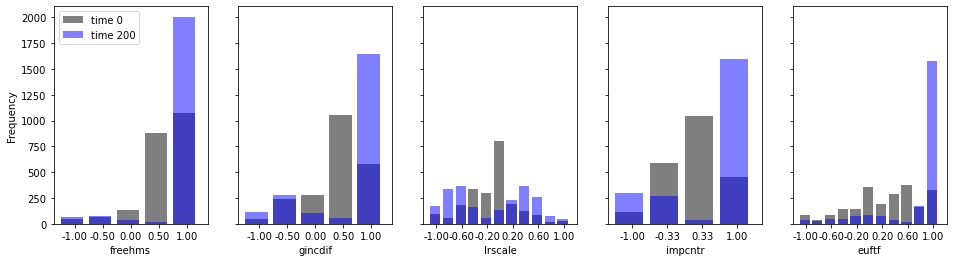

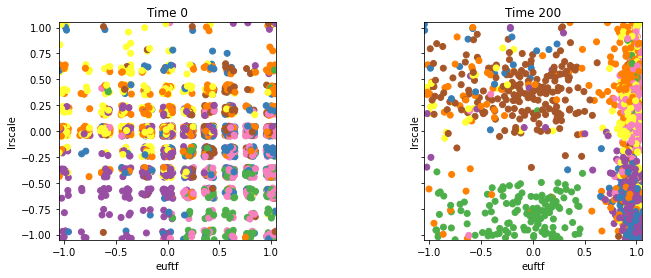

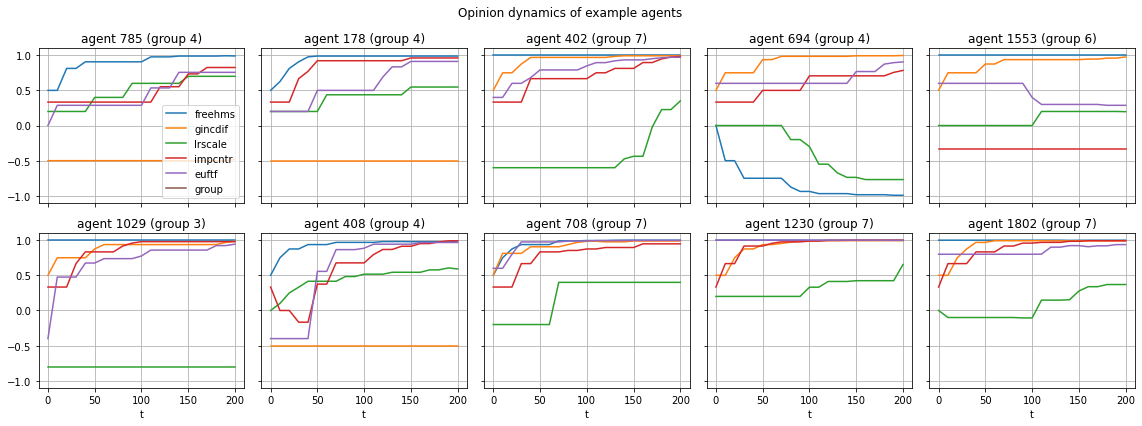

In [10]:
plot_beforeafter_hist(results, T=T)
compare_states(results, 0, T, "euftf", "lrscale")
plot_exampleagents(results, 10)



# Only self-coherence
- fixed social network
- no social influence


In [11]:
T = 200
track_times = np.arange(0,T+1,step=10)
params2 = copy.copy(params)
params2["alpha"] = 0.0
params2["beta"] = 1.0
ellapsed_time, results_2 = simulation(T, track_times, params2)
print("ellapsed time: {:} min and {:.1f} seconds".format(ellapsed_time[0], ellapsed_time[1])) 


ellapsed time: 0 min and 41.5 seconds


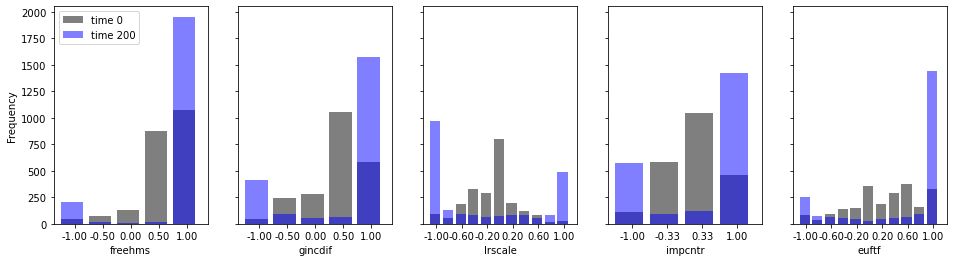

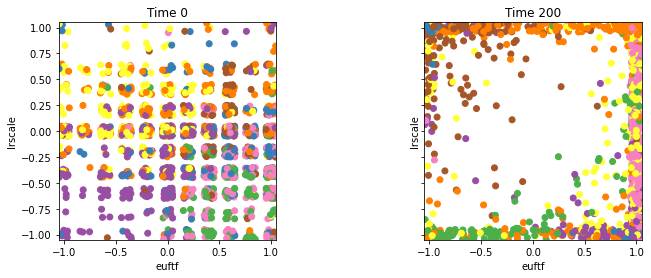

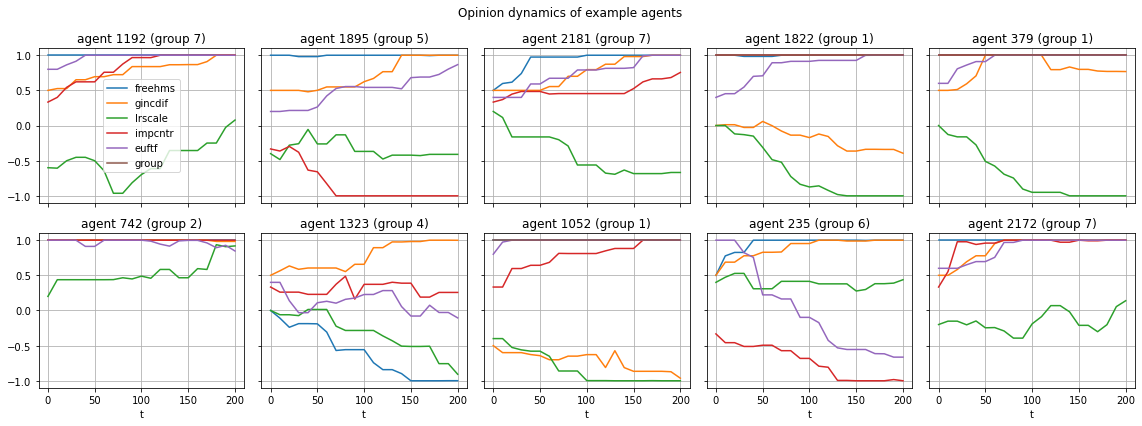

In [12]:
plot_beforeafter_hist(results_2, T=T)
compare_states(results_2, 0, T, "euftf", "lrscale")
plot_exampleagents(results_2, 10)

# Mixed: Social influence + self-coherence
- fixed social network

In [13]:
T = 200
track_times = np.arange(0,T+1,step=10)
params3 = copy.copy(params)
params3["alpha"] = 0.5
params3["beta"] = 0.5
ellapsed_time, results_3 = simulation(T, track_times, params3, verbose=True, save_network=True)
print("ellapsed time: {:} min and {:.1f} seconds".format(ellapsed_time[0], ellapsed_time[1])) 


10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, ...done
ellapsed time: 0 min and 41.8 seconds


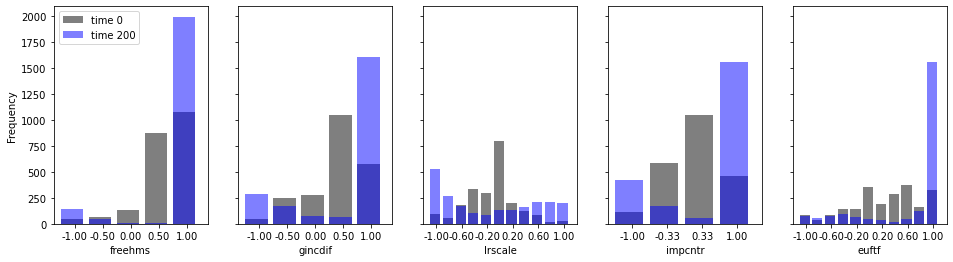

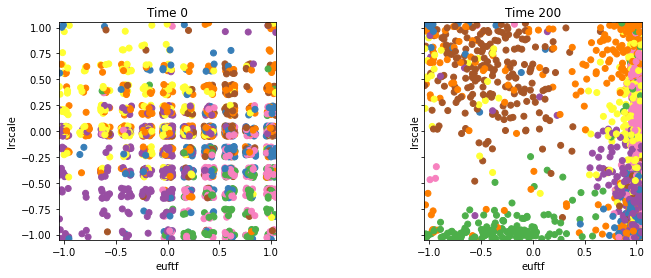

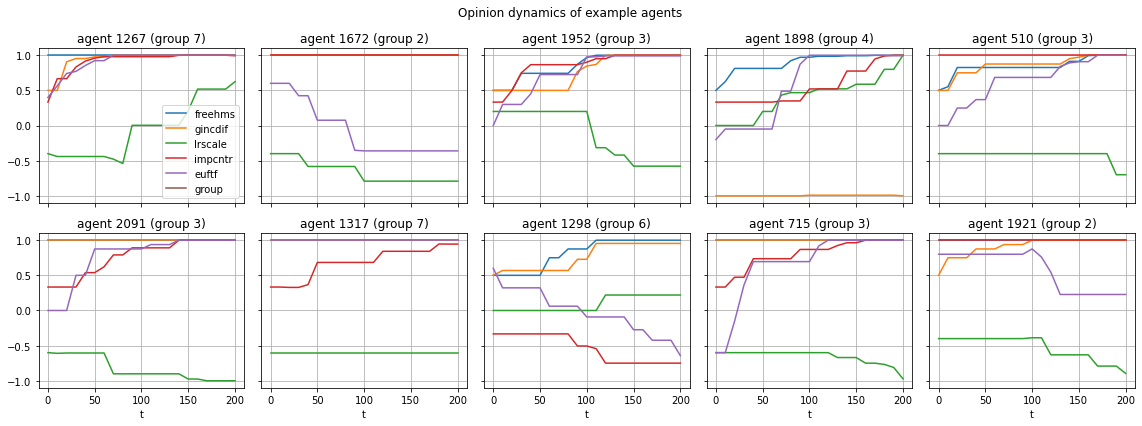

In [14]:
plot_beforeafter_hist(results_3, T=T)
compare_states(results_3, 0, T, "euftf", "lrscale")
plot_exampleagents(results_3, 10)

# Coherence is not so important as in the combined social-influence + self-coherence  
- fixed network
- social influence and self-coherence with 50% each
- logistic function translating coherence change into probability of adaptation is very flat

In [15]:
# results = main()
T = 200
track_times = np.arange(0,T+1, 10)
params4 = copy.copy(params3)
params4["k"] = 5
ellapsed_time, results_4 = simulation(T, track_times, params4, verbose=True, save_network=True)
print("ellapsed time: {:} min and {:.1f} seconds".format(ellapsed_time[0], ellapsed_time[1])) 


10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, ...done
ellapsed time: 0 min and 41.1 seconds


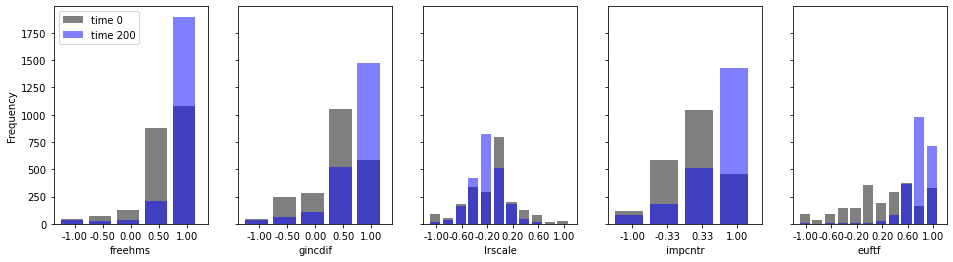

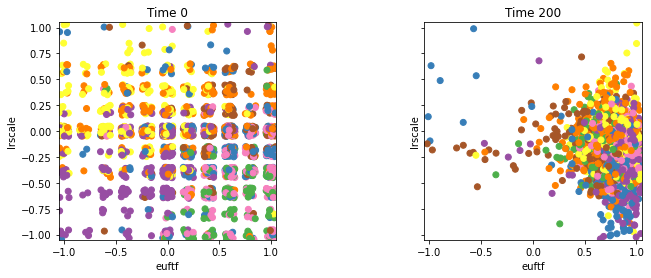

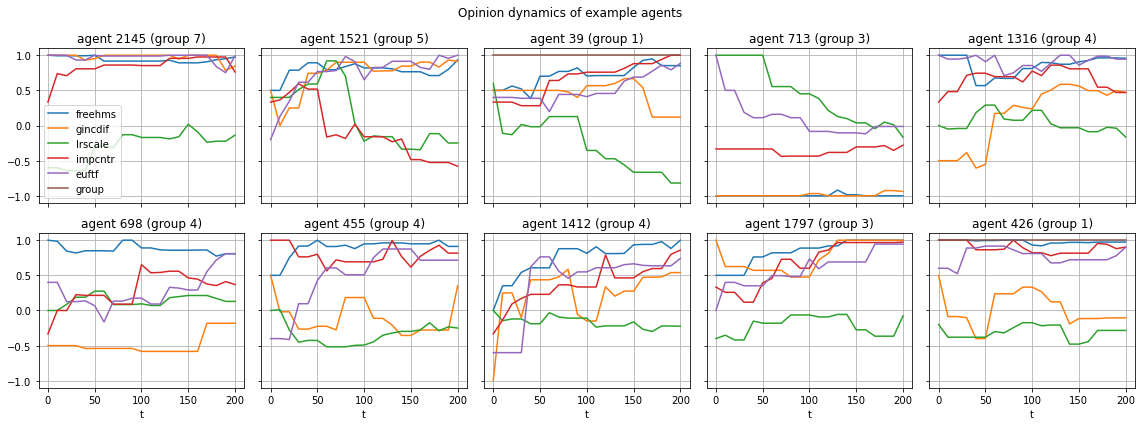

In [16]:
plot_beforeafter_hist(results_4, T=T)
compare_states(results_4, 0, T, "euftf", "lrscale")
plot_exampleagents(results_4, 10)

# TESTS

### Check how fast this runs and where the code spends most of its time

In [ ]:
#import cProfile
#import pstats
T = 200
track_times = np.arange(0,T+1,step=10)
params = dict(
    seed=42, 
    country="DE", 
    n_agents=2203, 
    k=10, 
    gamma=0., 
    beta=0., 
    alpha=1, 
    kappa=0.0, 
    th_cut_link=0.2,  # not used in this scenario
    n_attitudes=5, 
    noise = 0.1,  # not used in this scenario
    learning_rate=0.5,
    network_params={"type":"watts", "p":0.1, "k":10}, 
    init_beliefs="data" 
)
#with cProfile.Profile() as pr:
#       ellapsed_time, results = simulation(100, np.arange(100), params)
ellapsed_time, results = simulation(T, track_times, params)
print("ellapsed time: {:} min and {:.1f} seconds".format(ellapsed_time[0], ellapsed_time[1])) 

#stats = pstats.Stats(pr)
#stats.sort_stats(pstats.SortKey.TIME)
## Now you have two options, either print the data or save it as a file
#stats.print_stats() # Print The Stats
#stats.dump_stats("cprofile.prof")

### Matrices 

In [ ]:
m = Model(**params, save_network=False)
fig, axes = plt.subplots(1,6, figsize=(16,3))
for n, ax in enumerate(axes):
    ax.imshow(m.matrix_list[n], vmin=-1, vmax=1,cmap="bwr")
    ax.set_title("Group {}".format(n))
